In [1]:
# Import required packages
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import support_functions 

# Challenge: Predicting COVID-19 from chest CT scans

## Motivation

## Challenge

## Goal

# Load data

We first load the provided training images from folders. Loading is taken care of by `read_ct_scan` function.

In [2]:
# Get public covid, noncovid and normal images
base_path = os.path.join(os.getcwd(), '..', 'data', 'Images-processed')

noncovid_images = support_functions.read_ct_scan(os.path.join(base_path, 'CT_NonCOVID'))
covid_images = support_functions.read_ct_scan(os.path.join(base_path, 'CT_COVID'))

print('Total number of images: ')
print('Covid: ', len(noncovid_images))
print('Noncovid: ', len(covid_images))

Total number of images: 
Covid:  292
Noncovid:  251


Let's have a look at some noncovid and covid CT scans.

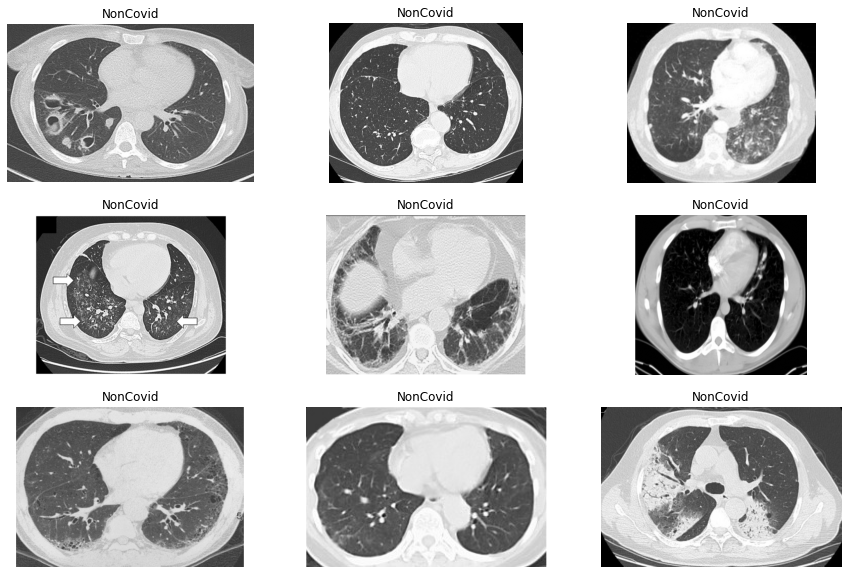

In [3]:
plt.figure(figsize=(15, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(noncovid_images[i]/255.)
    plt.axis("off")
    plt.title('NonCovid')

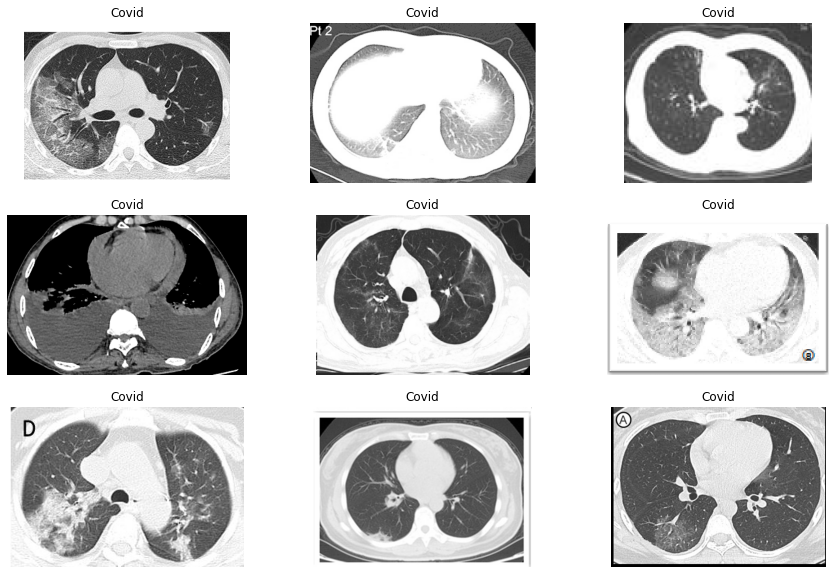

In [4]:
plt.figure(figsize=(15, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(covid_images[i]/255.)
    plt.axis("off")
    plt.title('Covid')

# Set up data for training

Let's create binary training labels for our covid and noncovid images, that is

- Noncovid: 0
- Covid: 1

The labels are required for our supervised classification task.

In [5]:
noncovid_labels = np.full(len(noncovid_images),fill_value=0)
covid_labels = np.full(len(covid_images),fill_value=1)

## Train-validation split

Here we reserve 20% of the data for validation. 

Note that, since some consecutive images may come from the same patient, they tend to be similar to each other. That is, our data is **not independent**. To prevent data leakage (information of training data spills over to validation data), we keep the original image sequence and hold out the last 20% as the validation set. 

After the splitting, we have two pairs of data:
1. `X_train`, `y_train`
2. `X_val`, `y_val`

X is a list of CT scans, and y is a list of binary labels.

In [6]:
# Train-validation split while keeping the order of the images
train_data_portion = 0.8 # Proportion of data for training

# Get integer number of training samples
train_covid_size = round(len(covid_images)*train_data_portion)
train_noncovid_size = round(len(noncovid_images)*train_data_portion)

# Split the dataset in its original sequence
X_train = noncovid_images[:train_noncovid_size] + covid_images[:train_covid_size]
y_train = np.concatenate((noncovid_labels[:train_noncovid_size], 
                          covid_labels[:train_covid_size]))

X_val = noncovid_images[train_noncovid_size:] + covid_images[train_covid_size:]
y_val = np.concatenate((noncovid_labels[train_noncovid_size:], 
                        covid_labels[train_covid_size:]))

print('Train-validation split:')
print('{} training images and {} validation images'.format(len(X_train), len(X_val)))

Train-validation split:
435 training images and 108 validation images


## Create `tf.data.Dataset` object

We create two `tf.data.Dataset` objects, one for training and the other for validation. 

The `tf.data.Dataset` API supports writing descriptive and efficient input pipelines. Essentially, it is a tensorflow data structure that greatly simplifies some essential operations, for example, preporcessing, shuffling and training. You can read more about it [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle).

In the `resize_and_shuffle` function, we 
1. create a `Dataset` object from a (`X, y`) pair,
2. resize each image to a standard size,
3. shuffle and split the data into batches for training later.

In [7]:
# Define global variables
IMG_SIZE = (256,256) # Standardize all images to this size
BATCH_SIZE = 32 # Number of training images for each gradient update
RANDOM_SEED = 123 # Random seed to ensure reproducibility

# Create training and validation Dataset objects
train_ds = support_functions.resize_and_shuffle(X_train, y_train, img_size=IMG_SIZE)
val_ds = support_functions.resize_and_shuffle(X_val, y_val, img_size=IMG_SIZE)

Since we have 435 training images, with a batch size of 32, we expect to get 14 batches of data. You can verify this by running the next cell.

In [8]:
train_ds.cardinality().numpy()

14

## Data augmentation

Here we use `tf.keras.Sequential` to create a pipeline in which the input image is randomly transformed through the following operations:
1. Random horizontal and vertical flip
2. Rotation by a random degree in the range of $[-5\%, 5\%]*2\pi$
3. Random zoom in height by $5\%$
4. Random translation by $5\%$
5. Random contrast adjustment by $5\%$

In [9]:
# Create data agumentation pipeline
augmentation_pipeline = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed=RANDOM_SEED),
        layers.experimental.preprocessing.RandomRotation((-0.05, 0.05), seed=RANDOM_SEED),
        layers.experimental.preprocessing.RandomZoom(-0.05, seed=RANDOM_SEED),
        layers.experimental.preprocessing.RandomTranslation(0.05, 0.05, seed=RANDOM_SEED),
        layers.experimental.preprocessing.RandomContrast(0.05, seed=RANDOM_SEED),
    ]
)

# Augment training data using augmentation pipeline
augmented_train_ds = train_ds.map(
    lambda x, y: (augmentation_pipeline(x, training=True), y))
train_ds = augmented_train_ds

**Be careful not to run the previous cell more than once as it will keep transforming the data.** If you have done so, you can rerun from "Create `tf.data.Dataset`" section to get the original data.

Let's see the effect of data augmentation.

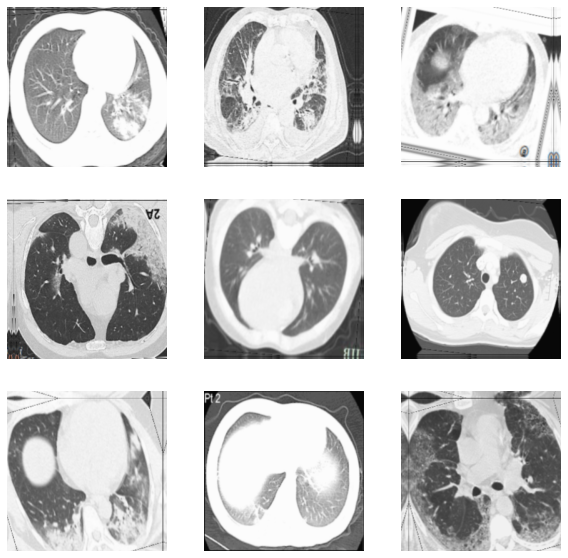

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i]/255.)
        plt.axis("off")

In [11]:
# train_ds = train_ds.prefetch(buffer_size=32)
# val_ds = val_ds.prefetch(buffer_size=32)

**Just a quick recap, we've done these so far:**
1. Loaded images from the folder.
2. Splitted data into two data sets: training and validation.
3. Randomly pertubed training images through an augmentation pipeline.

Now we are ready to make a CNN model for our classification task.

# Build CNN model

## Load pre-trained model

We first import a pre-trained CNN model and use it as our model backbone. 

The chosen model is [EfficientNetB0](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) and it belongs to the family of models called [EfficientNets](https://arxiv.org/abs/1905.11946) proposed by reseachers from Google.

EfficientNets are among the current state-of-the-art CNNs for computer vision tasks. They
1. require conconsiderably lower number of parameters
2. achieved very high accuracies on ImageNet
3. transferred well to other image classification tasks. 

Here's a performance comparison between EfficientNets and other well-known models:![EfficientNet](../img/efficientnets.png)

* EfficientNets, and other well-known pre-trained models, can be easily loaded from `tf.keras.applications`. 
* We specify the input image shape and remove the weights for the last classification layer. 
* Also, we freeze the model's weights so that they won't be updated during the initial training.

In [13]:
IMG_SHAPE = IMG_SIZE + (3,) # Add a third dimension for RGB channel

# Create a base model from the pre-trained EfficientNetB0
base_model = keras.applications.EfficientNetB0(input_shape=IMG_SHAPE, include_top=False)
base_model.trainable = False

## Wrap our model around it

Here we wrap our classification model around the base model imported above. The final model has
1. An input layer 
2. **EfficientNetB0 base model**
3. An average pooling layer: pool the information by average operation
4. A dropout layer: set a percentage of inputs to zero
5. A classification layer: outputs the probability of NonCovid

In [15]:
inputs = keras.Input(shape=IMG_SHAPE) # Input layer
x = base_model(inputs) # EfficientNetB0
x = layers.GlobalAveragePooling2D()(x) 
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # Classification layer
model = keras.Model(inputs, outputs) # Build the model

Let's take a look at our model's summary. We can see that:
1. The input layer has the correct image dimension of (256, 256, 3).
2. The `None` in output shape is a reserved place for the number of samples, which the model does not know yet.
2. EfficientNetB0 sits right after the input layer.
3. The last (classification) layer has output of dimension 1: NonCovid probability.
3. Most importantly, since we've frozen the parameters of EfficientNetB0, the number of trainable parameters is only 1281. 

In [16]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


Actually, `tf.keras.utils` provides a handy way to visulize the model that we've just created. 

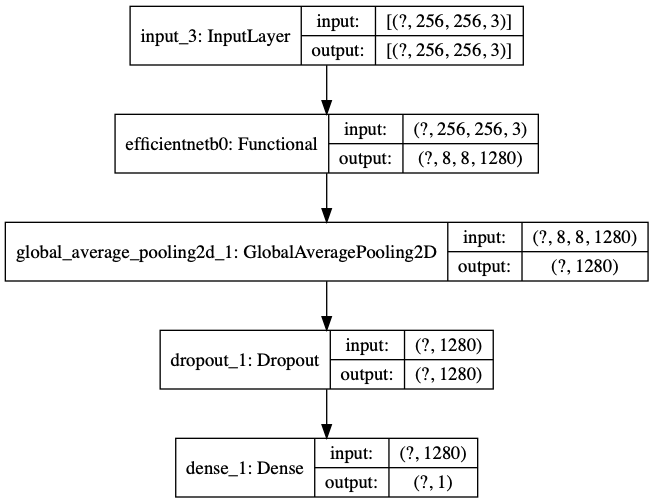

In [17]:
keras.utils.plot_model(model, show_shapes=True)

In [79]:
# Load pre-trained model weights
model.load_weights(os.path.join('..', 'saved_weights', 'pre_trained_weights')).expect_partial()

In [ ]:
# Specify optimizer, loss function and metrics
metrics =[keras.metrics.BinaryAccuracy(), keras.metrics.FalsePositives(),
            keras.metrics.TruePositives(), keras.metrics.FalseNegatives(),
            keras.metrics.TrueNegatives()]
loss = keras.losses.BinaryCrossentropy(from_logits=True)

# Create learning rate and epoch schedule
learning_rates = [1e-3, 1e-4, 1e-3, 2e-5]
training_epochs = [10, 30, 10, 30]

# Iteration 1: Feature extraction stage
model.compile(
    optimizer=keras.optimizers.Adam(learning_rates[0]),
    loss=loss,
    metrics=metrics,
)
hist = model.fit(train_ds, epochs=training_epochs[0])
# print('Iteration 1: Feature extraction completed.')

# Iteration 1: Fine tuning stage
base_model.trainable = True
fine_tune_at = 221
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False 

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rates[1]), 
    loss=loss,
    metrics=metrics
)
history_fine = model.fit(train_ds,
                         epochs=sum(training_epochs[:2]),
                         initial_epoch=hist.epoch[-1]
                        )
# print('Iteration 1: Fine tuning completed.')